# Анализ EM кластеризации на 1 элемент

## Загрузка

In [1]:
%matplotlib inline
from copy import deepcopy
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

from scipy.cluster.hierarchy import *
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist

import seaborn as sns; sns.set()
import h5py


## Рабочий датафрейм

### Импорт из EXCEL

In [2]:
data_store0 = pd.read_excel(r'C:\\Users\Sergey.Miklovda\Desktop\WORK_MATERIALS\VAE\VAE_2021\DataSet_Valunistoe.XLSX')
data_store0.head()

,id,Hole-ID,Sample,From,To,Au,Au_T,Au_T_revers,Ag,Ag_T,...,EM_3d(5_clusters),EM_3d(15_clusters),ORE,Xp,Yp,Zp,Elp,Elp_T,PCA1_w,PCA2_w
0,1,00-1,101,9.5,10.0,0.1,-2.282,0.109,2.5,-0.290,...,2,3,0,0.9,0.586,0.887,0.294,-0.607362,-0.243305,-0.787627
1,2,00-1,102,10.0,11.0,4.5,1.902,4.496,91.5,1.943,...,2,3,1,0.9,0.586,0.887,0.580,1.479153,1.204270,-0.439757
2,3,00-1,103,11.0,12.0,5.0,1.929,5.002,74.2,1.839,...,2,3,1,0.9,0.586,0.886,0.587,1.526383,1.261401,-0.497378
3,4,00-1,104,12.0,13.0,2.1,-2.003,2.107,52.2,1.659,...,2,3,1,0.9,0.586,0.885,0.528,1.146982,0.788742,-0.025209
4,5,00-1,105,13.0,14.0,0.1,-2.282,0.109,2.5,-0.290,...,2,3,0,0.9,0.586,0.884,0.134,-1.998030,-0.244490,-0.786441


### Импорт из HDF5 файла

In [7]:
# Подгружаем данные из файла h5
Valunistoe_Store = pd.HDFStore(r'C:\\Users\Sergey.Miklovda\Desktop\WORK_MATERIALS\VAE\VAE_2021\Valunistoe_Store.h5')

with h5py.File(Valunistoe_Store, 'r') as f:
    for key in f.keys():
        print(key)

202110


In [8]:
# Выводим данные из нужной таблицы в рабочий датафрейм
data_store0 = Valunistoe_Store['202110']
data_store0.describe()

KeyError: 'No object named 202110 in the file'

In [ ]:
# Один раз!____________________________________________________
# Создаем файл HDF5____________________________________________
#Valunistoe_Store = pd.HDFStore(r'C:\\Users\Sergey.Miklovda\Desktop\WORK_MATERIALS\VAE\VAE_2021\Valunistoe_Store.h5')

# по необходимости______________________________________________
# Создаем копию датафрейма для занесения в отдельную таблицу hdf5___________
#Valunistoe_202110 = data_store0.copy()
# Записываем в файл HDF5 данные из датафрейма________________
#Valunistoe_Store['202110'] = Valunistoe_202110 # сохранение произошло таблицу с выбранными данными

In [9]:
# список столбцов.
data_columns = data_store0.columns # список столбцов
data_columns

Index(['id', 'Hole-ID', 'Sample', 'From', 'To', 'Au', 'Au_T', 'Au_T_revers',
       'Ag', 'Ag_T', 'X', 'Y', 'Z', 'Lit', 'Min', 'Tect', 'Type', 'Au_rand',
       'Au_rand_T', 'Au_rand_T_revers', 'EM_cluster', 'EM_2d(7_clusters)',
       'EM_3d(5_clusters)', 'EM_3d(15_clusters)', 'ORE', 'Xp', 'Yp', 'Zp',
       'Elp', 'Elp_T', 'PCA1_w', 'PCA2_w'],
      dtype='object')

### Дата фрейм для расчетов по одному элементу

In [10]:
#__________Выбираем столбцы для работы__________________
data_store = data_store0[['Hole-ID', 'Sample', 'From', 'To', 'Au','Au_rand']]
data_store[:3]

,Hole-ID,Sample,From,To,Au,Au_rand
0,00-1,101,9.5,10.0,0.1,0.071
1,00-1,102,10.0,11.0,4.5,4.500
2,00-1,103,11.0,12.0,5.0,5.000


In [11]:
data_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184303 entries, 0 to 184302
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Hole-ID  184303 non-null  object 
 1   Sample   184278 non-null  object 
 2   From     184303 non-null  float64
 3   To       184303 non-null  float64
 4   Au       184303 non-null  float64
 5   Au_rand  184303 non-null  float64
dtypes: float64(4), object(2)
memory usage: 8.4+ MB


### Преобразование форматов и очистка выпадающих значений

In [12]:

# Преобразуем формат float
for i in data_store.columns:
    if(data_store[i].dtype == 'float64' or data_store[i].dtype == 'int64'):
        data_store[i]= data_store[i].astype('float32')
        
data_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184303 entries, 0 to 184302
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Hole-ID  184303 non-null  object 
 1   Sample   184278 non-null  object 
 2   From     184303 non-null  float32
 3   To       184303 non-null  float32
 4   Au       184303 non-null  float32
 5   Au_rand  184303 non-null  float32
dtypes: float32(4), object(2)
memory usage: 5.6+ MB


<ipython-input-12-5e974b3063b0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_store[i]= data_store[i].astype('float32')


### Ураганы

In [ ]:
# УРАГАНЫ
for i in range(0, len(data_store)):
    if data_store['Au'][i] > 950: #75.93
        data_store['Au'][i] = 950
    #if data_store['Ag'][i] > 627:
        #data_store['Ag'][i] = 627
    #if data_store['Pb'][i] > 20.04:
        #data_store['Pb'][i] = 20.04
    #if data_store['Zn'][i] > 20.72:
        #data_store['Zn'][i] = 20.72       
        #print(data['Au'][i])

data_store.describe()   

## Определяем базовый элемент

(array([1.82252e+05, 1.15100e+03, 3.18000e+02, 1.67000e+02, 1.15000e+02,
        5.30000e+01, 4.60000e+01, 3.30000e+01, 2.90000e+01, 2.00000e+01,
        1.30000e+01, 1.00000e+01, 6.00000e+00, 1.40000e+01, 6.00000e+00,
        2.00000e+00, 6.00000e+00, 8.00000e+00, 5.00000e+00, 8.00000e+00,
        1.00000e+00, 3.00000e+00, 3.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 3.00000e+00, 0.00000e+00, 1.00000e+00, 2.00000e+00,
        0.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00, 1.00000e+00,
        3.00000e+00, 1.00000e+00, 1.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 4.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

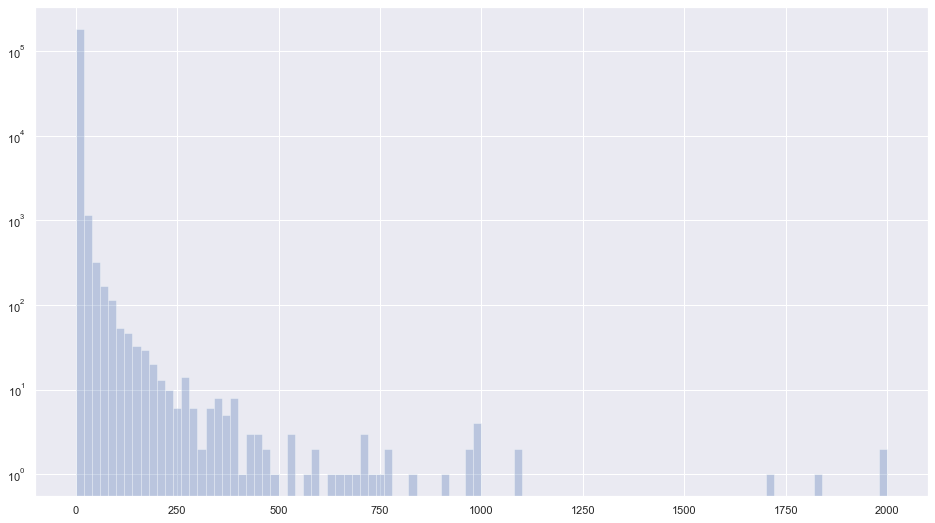

In [13]:
el = 'Au_rand'
#data_store[el].describe()
X= data_store[el].dropna()
plt.yscale('log')

kwargs = dict(histtype= 'bar', alpha=0.3,  bins=100) #normed= True,
plt.hist(X, **kwargs) #np.log(X)

### Ограничение выдающихся значения по базовому элементу

#### Создание словаря количества встречаемости значений элемента

In [19]:
# ____ОПРЕДЕЛЯЕМ УРОВНИ ДЛЯ ОЧИСТКИ ВЫБОРКИ___________
# Вычисляем количество уникальных записей по столбцам
# Одновременно создаем ДатаФреймы из этих записей

In [20]:
# Создание словаря количества встречаемости значений элемента

counter = {}
data_store[el] =  pd.to_numeric((data_store[el]), errors='coerce').map('{:,.3f}'.format)# Преоразование в numeric!
for key in data_store[el].tolist():
    counter[key] = counter.setdefault(key,0) + 1

#sorted_tuple = sorted(counter.items(), key=lambda x: x[0]) # Сортировка по ключу
sorted_tuple = sorted(counter.items(), key=lambda x: -x[1]) # Сортировка по значению в обратном направлении
print(sorted_tuple[:5])
#print(type(counter[key]), type(counter), type(counter.items()), type(sorted_tuple))
#print(sorted_tuple[0][0],sorted_tuple[0][1] )

[('0.120', 2828), ('0.110', 2822), ('0.130', 2421), ('0.140', 2401), ('0.250', 2341)]


<ipython-input-20-2f9c6f3337ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_store[el] =  pd.to_numeric((data_store[el]), errors='coerce').map('{:,.3f}'.format)# Преоразование в numeric!


#### Очистка значений 'nan' с созданием  датафрейма с одной колонкой

In [21]:
store_nan_out = []
count_nan = []
data_store[el] =  pd.to_numeric((data_store[el]), errors='coerce').map('{:,.3f}'.format)# Преоразование в numeric!
for i in range(0, len(data_store[el])):
    if data_store[el][i] != 'nan':
        store_nan_out.append(data_store[el][i])
    else:
        count_nan.append(data_store[el][i])
new_store = pd.Series(store_nan_out)
print(new_store.head(3))
print("Урезанных значений - ",len(store_nan_out), "   Значений ", " 'nan'", "-", len(count_nan)) 
print("Всего: ", len(store_nan_out) + len(count_nan))
#print("Тип data_store[el] - ", type(data_store[el]))
#print("Тип store_nan_out -", type(store_nan_out))
#print("Тип new_store -", type(new_store))
#print("Тип new_store.dtypes -",new_store.dtypes)

<ipython-input-21-42f5d710ea38>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_store[el] =  pd.to_numeric((data_store[el]), errors='coerce').map('{:,.3f}'.format)# Преоразование в numeric!


0    0.071
1    4.500
2    5.000
dtype: object
Урезанных значений -  184294    Значений   'nan' - 9
Всего:  184303


#### Очистка значений 'nan' в исходном датафреейме с одним элементом

In [22]:

data_store_not_nan= data_store[data_store.Au_rand !='nan'][['Hole-ID', 'Sample', 'From', 'To', 'Au','Au_rand']]
print(data_store_not_nan.head(3))
print(len(data_store_not_nan))

  Hole-ID Sample  From    To   Au Au_rand
0    00-1    101   9.5  10.0  0.1   0.071
1    00-1    102  10.0  11.0  4.5   4.500
2    00-1    103  11.0  12.0  5.0   5.000
184294


In [23]:
data_store_not_nan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184294 entries, 0 to 184302
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Hole-ID  184294 non-null  object 
 1   Sample   184269 non-null  object 
 2   From     184294 non-null  float32
 3   To       184294 non-null  float32
 4   Au       184294 non-null  float32
 5   Au_rand  184294 non-null  object 
dtypes: float32(3), object(3)
memory usage: 7.7+ MB


#### График логарифмированных значений (без 'nan')

(array([184294.]),
 array([-6.90775528,  6.90070045]),
 <BarContainer object of 1 artists>)

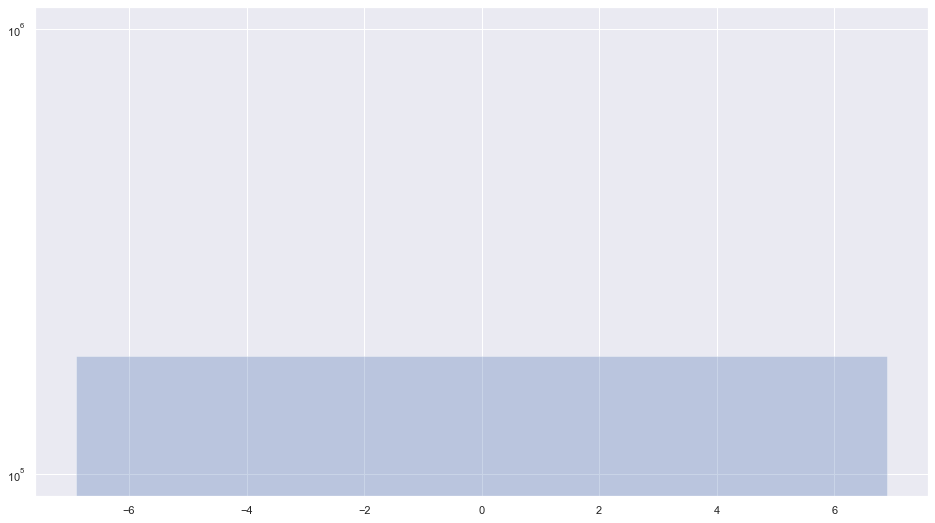

In [24]:
X = pd.to_numeric(new_store)
plt.yscale('log')
kwargs = dict(histtype= 'bar', alpha=0.3,  bins=1) #normed= True,
plt.hist(np.log(X), **kwargs) #np.log(X)

(array([3.5300e+02, 0.0000e+00, 7.2700e+02, 7.0100e+02, 0.0000e+00,
        1.3910e+03, 6.9800e+02, 2.0960e+03, 2.2820e+03, 2.0250e+03,
        3.4670e+03, 5.0420e+03, 6.2550e+03, 7.6730e+03, 1.0581e+04,
        1.4018e+04, 1.1528e+04, 1.0472e+04, 1.1357e+04, 1.0230e+04,
        1.5483e+04, 8.7050e+03, 6.9780e+03, 6.3010e+03, 5.8730e+03,
        5.5100e+03, 5.4100e+03, 5.0080e+03, 4.6220e+03, 4.3980e+03,
        3.8190e+03, 3.1040e+03, 2.4640e+03, 1.7750e+03, 1.2040e+03,
        7.9400e+02, 5.5500e+02, 3.9000e+02, 2.7300e+02, 1.8500e+02,
        1.6100e+02, 1.2000e+02, 8.0000e+01, 6.7000e+01, 3.5000e+01,
        2.9000e+01, 2.6000e+01, 1.1000e+01, 1.1000e+01, 7.0000e+00]),
 array([-6.90775528e+00, -6.63158616e+00, -6.35541705e+00, -6.07924794e+00,
        -5.80307882e+00, -5.52690971e+00, -5.25074059e+00, -4.97457148e+00,
        -4.69840236e+00, -4.42223325e+00, -4.14606413e+00, -3.86989502e+00,
        -3.59372590e+00, -3.31755679e+00, -3.04138767e+00, -2.76521856e+00,
        -2.489

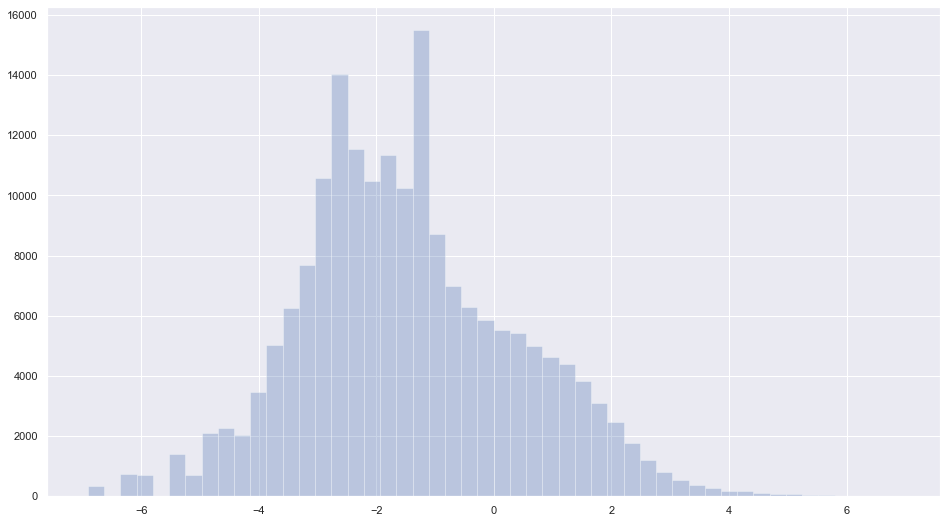

In [25]:
X = pd.to_numeric(new_store)
kwargs = dict(histtype= 'bar',  alpha=0.3,  bins=50) #normed= True,
plt.hist(np.log(X), **kwargs)

### Цикл нормализации аномальных значений

In [ ]:
type(new_store)
#new_store.dtypes
new_store

In [ ]:
data_store_not_nan['Au_base'] = new_store.tolist()
data_store_not_nan

In [ ]:
X= pd.to_numeric(data_store_not_nan['Au_base'])
#X= pd.to_numeric(new_store)
Y= pd.to_numeric(data_store_not_nan['Au'])
#plt.yscale('log')
kwargs = dict(histtype= 'bar', alpha=0.3,  bins=50) #normed= True,
plt.hist(np.log(X), **kwargs) #np.log(X)
plt.hist(np.log(Y), **kwargs) #np.log(X)

#### Разделение данных на выборки. Выборка для распределения + выборка без аномальных значений

In [ ]:
count = []
store = []
for i in range(0, len(new_store)):
    if new_store[i] != sorted_tuple[0][0]:
        store.append(new_store[i])
    else:
        count.append(new_store[i])
print("Урезанных значений - ",len(store), "   Значений ", sorted_tuple[0][0], "-", len(count))   
print("Всего: ", len(store)+ len(count))
print(float(sorted_tuple[0][0]))
print(type(sorted_tuple[0][0]))
print(type(float(sorted_tuple[0][0])))
print(sorted_tuple[0][0])
print(float(sorted_tuple[0][0]))


#### Распределение данных в выборке аномальных значений

##### А. Разброс в пределах округления, если значение не пороговое!

In [ ]:

# Распределение значений в выдающихся столбцах!!!
znak = float(sorted_tuple[0][0])
rand0 = np.random.uniform(znak-0.01, znak+0.01 ,len(count))# разброс случайных значений на количество в колонке
rand = rand0.tolist()

##### Б. Разброс ниже порогового значения, если значение пороговое!

In [ ]:
# Распределение значений в выдающихся столбцах!!!
znak = float(sorted_tuple[0][0])
rand0 = np.random.uniform(0.0009, znak ,len(count))# разброс случайных значений на количество в колонке
rand = rand0.tolist()

##### Выборки результата разброса значений.

In [ ]:
pds1= pd.Series(rand0)
print("Объект Series случайных величин по выдающемуся значению -",
      znak,
      "  Длина - ",
      len(pds1))
#---------------------------------------------------------------
  
print("Исходный объект Series по одному элементу без значений -",
      znak,
      "  Длина - ",
      len(store))   
    
#-------------------------------------------------------------------


#### Соединение данных расчитанных с основными

In [ ]:
# Объединяем датафрейм без строки с расчитанным случайным образом одномерным массивом
stores = pd.Series(store)
values_data_store_el = stores.values
values_pds1 = pds1.values
values_new_series = np.concatenate([stores.values,pds1.values])
print("Длина сумарного массива", 
      len(values_new_series),
      "Проверка:",
      len(stores), "+" ,
      len(pds1), "=", int(len(stores)) + int(len(pds1)))
#data_store_new = data_store_el.add(rand1)
print("Длина исходного массива до операций - ", len(values_new_series)) #len(store)+ len(count)

values_new_series =  pd.to_numeric(pd.Series(values_new_series), errors='coerce').map('{:,.3f}'.format)# Преобразование в numeric!
vs = pd.Series(values_new_series)

print("Набор данных с расбросанными значениями первого выдающего элемента ", vs.head(3), '   ...', vs.tail(3))
print("Тип набора данных: ", type(vs))

#### Частота встречаемости содержаний после коррекции аномального элемента

In [ ]:
counter_new = {}
vs =  pd.to_numeric((vs), errors='coerce').map('{:,.3f}'.format)# Преоразование в numeric!

for key in vs.tolist():
    counter_new[key] = counter_new.setdefault(key,0) + 1

#sorted_tuple = sorted(counter.items(), key=lambda x: x[0]) # Сортировка по ключу
data_store_new = sorted(counter_new.items(), key=lambda x: -x[1]) # Сортировка по значению в обратном направлении
print(data_store_new[:5])


#### Проверка данных на наличие нулевых значений

In [ ]:
x_new = pd.to_numeric(vs)
x_new.describe()

##### Приращение нулевых значений
В случае отсутсвия нулевых значений, пропустить выполнение


In [ ]:
count=[]
for i in range(0, len(x_new)):
    if x_new[i] != x_new.min():
        x_new[i] = str(x_new[i])
    else:
        x_new[i] = str(x_new[i]+ 0.001) 
        count.append(x_new[i])
print("Заменено ", len(count), "значений")

vs = pd.Series(x_new).astype('object')# преобразование в тип object
print("Преобразованный тип дандных vs.dtypes ", vs.dtypes)
vs =  pd.to_numeric((vs), errors='coerce').map('{:,.3f}'.format)# Преоразование в str с 3-мя знаками!
print("Тип значений в выборке ", type(vs.values[1]))

#### Повторение цикла нормализации данных (по необходимости)

In [ ]:
new_store = vs # Присвоение нормализованных данных начальному набору для дальнейшей очистки
sorted_tuple = data_store_new # Присвоение набора отсортированных значений
print(new_store)
print(sorted_tuple[:5])

### Построение гистограмм откоректированных данных

In [26]:
#yscale('log')
X= pd.to_numeric(vs)
plt.yscale('log')
plt.xscale('log')
kwargs = dict(histtype= 'bar',  alpha=0.3,  bins=50) #normed= True,
plt.hist(X, **kwargs) #np.log(X)

NameError: name 'vs' is not defined

In [15]:
#np.log(X)
X= pd.to_numeric(vs)
Y= pd.to_numeric(store_nan_out)

kwargs = dict(histtype= 'bar',  alpha=0.3,  bins=60) #normed= True,
plt.hist(np.log(X), **kwargs)
plt.hist(np.log(Y), **kwargs)#np.log(X) для блокировки 0 значений логарифма добавлям малую величину!

NameError: name 'vs' is not defined

In [ ]:
# yscale('log'), np.log(X)
X= pd.to_numeric(vs)
Y= pd.to_numeric(data_store_not_nan['Au'])
plt.yscale('log')
kwargs = dict(histtype= 'bar',  alpha=0.3,  bins=50) #normed= True,
plt.hist(np.log(X), **kwargs) #np.log(X) для блокировки 0 значений логарифма добавлям малую величину!
plt.hist(np.log(Y), **kwargs)

## Подготавливаем исходный датафрейм x

### Из исходного набора

(array([3.5300e+02, 0.0000e+00, 7.2700e+02, 7.0100e+02, 0.0000e+00,
        1.3910e+03, 6.9800e+02, 2.0960e+03, 2.2820e+03, 2.0250e+03,
        3.4670e+03, 5.0420e+03, 6.2550e+03, 7.6730e+03, 1.0581e+04,
        1.4018e+04, 1.1528e+04, 1.0472e+04, 1.1357e+04, 1.0230e+04,
        1.5483e+04, 8.7050e+03, 6.9780e+03, 6.3010e+03, 5.8730e+03,
        5.5100e+03, 5.4100e+03, 5.0080e+03, 4.6220e+03, 4.3980e+03,
        3.8190e+03, 3.1040e+03, 2.4640e+03, 1.7750e+03, 1.2040e+03,
        7.9400e+02, 5.5500e+02, 3.9000e+02, 2.7300e+02, 1.8500e+02,
        1.6100e+02, 1.2000e+02, 8.0000e+01, 6.7000e+01, 3.5000e+01,
        2.9000e+01, 2.6000e+01, 1.1000e+01, 1.1000e+01, 7.0000e+00]),
 array([-6.90775528e+00, -6.63158616e+00, -6.35541705e+00, -6.07924794e+00,
        -5.80307882e+00, -5.52690971e+00, -5.25074059e+00, -4.97457148e+00,
        -4.69840236e+00, -4.42223325e+00, -4.14606413e+00, -3.86989502e+00,
        -3.59372590e+00, -3.31755679e+00, -3.04138767e+00, -2.76521856e+00,
        -2.489

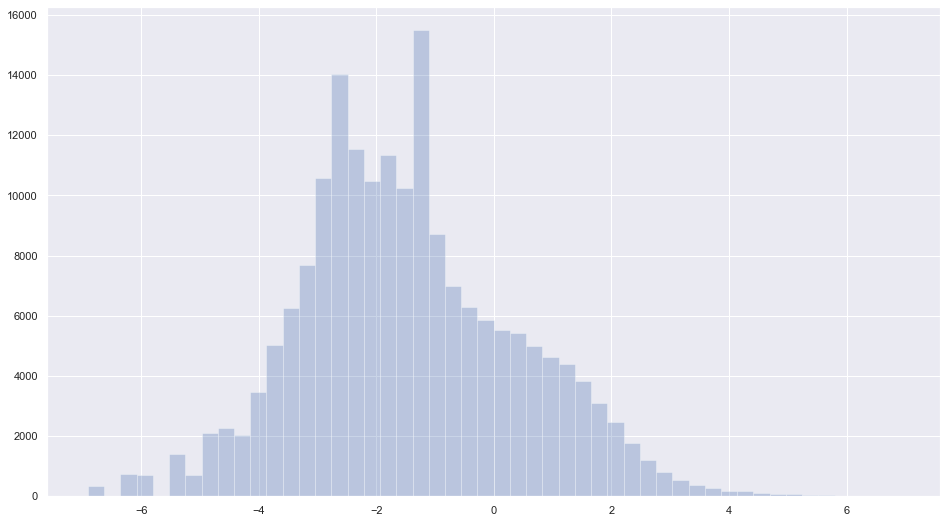

In [27]:
x0 = pd.to_numeric(store_nan_out)
kwargs = dict(histtype= 'bar',  alpha=0.3,  bins=50) #normed= True,
plt.hist(np.log(x0), **kwargs)

In [28]:
x= pd.Series(store_nan_out).astype('float32')
x= np.log(x)
x.describe()

count    184294.000000
mean         -1.458115
std           1.860915
min          -6.907755
25%          -2.718101
50%          -1.560648
75%          -0.287682
max           6.900701
dtype: float64

### Из "очищенного" набора

In [18]:
x= x_new
#x = data_store_el[0].dropna()
# Логарифмирование данных
x= np.log(x)
x.describe()

NameError: name 'x_new' is not defined

## Массив признаков

In [29]:
# СОЗДАНИЕ МАССИВА ПРИЗНАКОВ (ОДНОМЕРНОГО)
X  = np.array(x.values[:, np.newaxis]) # x.values преобразование из сериес в массив
X.shape
#q = np.array(x,)
#q.shape

(184294, 1)

## Предварительный анализ модели

### Обучение модели для анализа

In [30]:
#ОБУЧЕНИЕ МОДЕЛИ НА 1-10 КОМПОНЕНТАХ
k_arr = np.arange(10)+1

models = [
GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X)
for k in k_arr
]

### Вывод на гистограммы

In [31]:
# ФУНКЦИЯ ПЕЧАТИ
def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()
    # Compute PDF of whole mixture
    x = np.linspace(-6, 6, 1000)
    logprob = gmm.score_samples(x.reshape(-1, 1))
    pdf = np.exp(logprob)
    # Compute PDF for each component
    responsibilities = gmm.predict_proba(x.reshape(-1, 1))
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    # Plot data histogram
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label ='Data')
    # Plot PDF of whole model
    ax.plot(x, pdf, '-k', label='Mixture PDF')
    # Plot PDF of each component
    ax.plot(x, pdf_individual, '--', label='Component PDF')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()

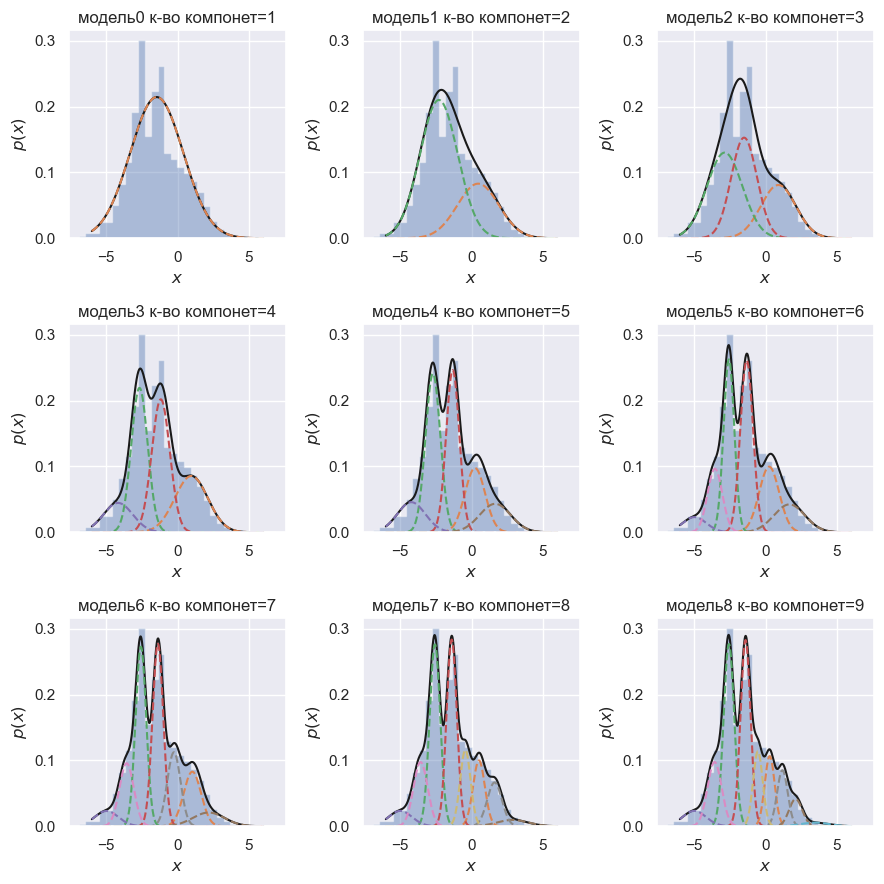

In [32]:
# ВИЗУАЛИЗАЦИЯ ВСЕХ КОМПОНЕНТОВ С 1 ПО 9
_, axes = plt.subplots(3, 3, figsize=np.array([3,3])*3, dpi=100)
for gmm, ax in zip(models, axes.ravel()):

    plot_mixture(gmm, X, show_legend=False, ax=ax)
    ax.set_title(f'модель{gmm.n_components-1} к-во компонет={gmm.n_components}')
plt.tight_layout()

### Определение количества компонент по графику AIC, BIC


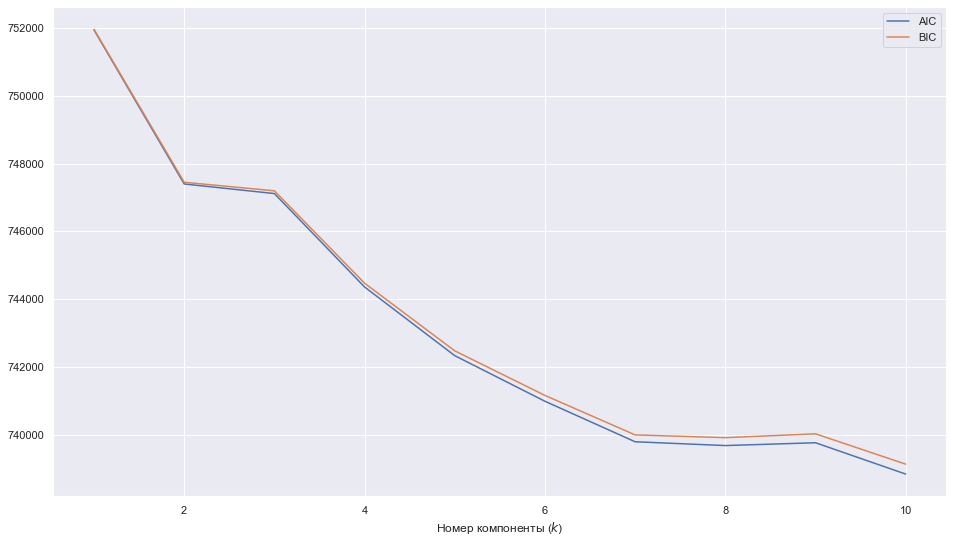

In [33]:
# Compute metrics to determine best hyperparameter
AIC = [m.aic(X) for m in models]
BIC = [m.bic(X) for m in models]
# Plot these metrics
plt.plot(k_arr, AIC, label='AIC')
plt.plot(k_arr, BIC, label='BIC')
plt.xlabel('Номер компоненты ($k$)')
plt.legend()


### Гистограмма по отдельному компоненту модели

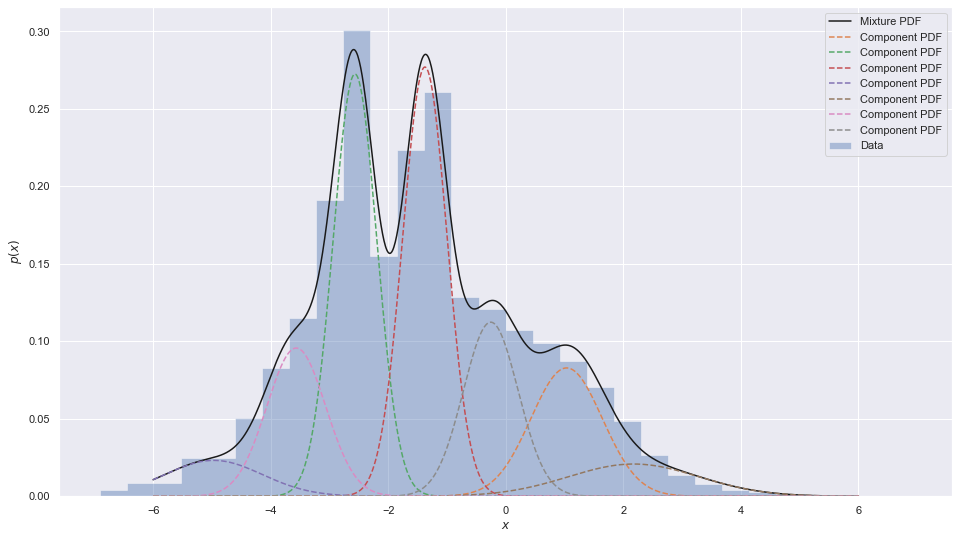

In [35]:

#[np.argmin(AIC)] #- Графически расчитанная модель
N_model=6 #-номер принятой модели (N_model +1)

#gmm_best = models[np.argmin(AIC)]
#plot_mixture(gmm_best, X)
gmm_optimal = models[N_model]
plot_mixture(gmm_optimal,X)

## Обучение модели (по расчитанным компонентам) и предикт значений в исходный фрейм

In [38]:
gmm = GaussianMixture(n_components=N_model + 1)
gmm.fit(X)
data_store_el=data_store_not_nan
data_store_el.loc[:,'EM_Cluster'] = gmm.predict(X)

for n in range(0, N_model+1):
    print("means_" , n , gmm.means_[n].round(3),
          "covariances", n , gmm.covariances_[n].round(3),
    "Значения приведены к логарифмическому виду!")
print(data_store_el.tail(3))
data_store_el.shape    
 

means_ 0 [1.208] covariances 0 [[0.34]] Значения приведены к логарифмическому виду!
means_ 1 [-2.512] covariances 1 [[0.149]] Значения приведены к логарифмическому виду!
means_ 2 [-0.118] covariances 2 [[0.229]] Значения приведены к логарифмическому виду!
means_ 3 [-3.486] covariances 3 [[0.259]] Значения приведены к логарифмическому виду!
means_ 4 [-1.325] covariances 4 [[0.135]] Значения приведены к логарифмическому виду!
means_ 5 [-4.919] covariances 5 [[0.695]] Значения приведены к логарифмическому виду!
means_ 6 [2.42] covariances 6 [[1.195]] Значения приведены к логарифмическому виду!
          Hole-ID     Sample        From          To    Au Au_rand  EM_Cluster
184300  VD-20-105  V20105066  197.699997  198.800003  0.05   0.068           1
184301  VD-20-105  V20105067  198.800003  199.899994  0.05   0.067           1
184302  VD-20-105  V20105068  199.899994  201.000000  0.05   0.083           1


(184294, 7)

In [39]:
data_store_el

,Hole-ID,Sample,From,To,Au,Au_rand,EM_Cluster
0,00-1,101,9.500000,10.000000,0.10,0.071,1
1,00-1,102,10.000000,11.000000,4.50,4.500,0
2,00-1,103,11.000000,12.000000,5.00,5.000,0
3,00-1,104,12.000000,13.000000,2.10,2.135,0
4,00-1,105,13.000000,14.000000,0.10,0.007,5
...,...,...,...,...,...,...,...
184298,VD-20-105,V20105064,195.699997,196.699997,0.05,0.020,3
184299,VD-20-105,V20105065,196.699997,197.699997,0.05,0.064,1
184300,VD-20-105,V20105066,197.699997,198.800003,0.05,0.068,1
184301,VD-20-105,V20105067,198.800003,199.899994,0.05,0.067,1


In [40]:
data_store_el['Au_base']= new_store.tolist()
data_store_el

,Hole-ID,Sample,From,To,Au,Au_rand,EM_Cluster,Au_base
0,00-1,101,9.500000,10.000000,0.10,0.071,1,0.071
1,00-1,102,10.000000,11.000000,4.50,4.500,0,4.500
2,00-1,103,11.000000,12.000000,5.00,5.000,0,5.000
3,00-1,104,12.000000,13.000000,2.10,2.135,0,2.135
4,00-1,105,13.000000,14.000000,0.10,0.007,5,0.007
...,...,...,...,...,...,...,...,...
184298,VD-20-105,V20105064,195.699997,196.699997,0.05,0.020,3,0.020
184299,VD-20-105,V20105065,196.699997,197.699997,0.05,0.064,1,0.064
184300,VD-20-105,V20105066,197.699997,198.800003,0.05,0.068,1,0.068
184301,VD-20-105,V20105067,198.800003,199.899994,0.05,0.067,1,0.067


In [1]:
# Вывод в Excel
out_path = r'C://Users/Sergey.Miklovda/Desktop/WORK_MATERIALS/VAE/VAE_2021/Valunistoe_EM.xlsx'
#input("Введите путь к файлу вывода__")
data_store_el.to_excel(out_path)

NameError: name 'data_store_el' is not defined

In [42]:
mu0 = float(gmm.means_[0])
sigma0 = float(gmm.covariances_[0])
s0 = np.random.normal(mu0, sigma0, 10000).T
s00 = np.random.normal(mu0, sigma0, 10000).T

mu1 = float(gmm.means_[1])
sigma1 = float(gmm.covariances_[1])
s1 = np.random.normal(mu1, sigma1, 10000)
s11 = np.random.normal(mu1, sigma1, 10000)

"""
mu2 = float(gmm.means_[2])
sigma2 = float(gmm.covariances_[2])
s2 = np.random.normal(mu2, sigma2, 10000)
s22 = np.random.normal(mu1, sigma1, 10000)

mu3 = float(gmm.means_[3])
sigma3 = float(gmm.covariances_[3])
s3 = np.random.normal(mu3, sigma3, 100000)
s33 = np.random.normal(mu1, sigma1, 100000)"""

'\nmu2 = float(gmm.means_[2])\nsigma2 = float(gmm.covariances_[2])\ns2 = np.random.normal(mu2, sigma2, 10000)\ns22 = np.random.normal(mu1, sigma1, 10000)\n\nmu3 = float(gmm.means_[3])\nsigma3 = float(gmm.covariances_[3])\ns3 = np.random.normal(mu3, sigma3, 100000)\ns33 = np.random.normal(mu1, sigma1, 100000)'

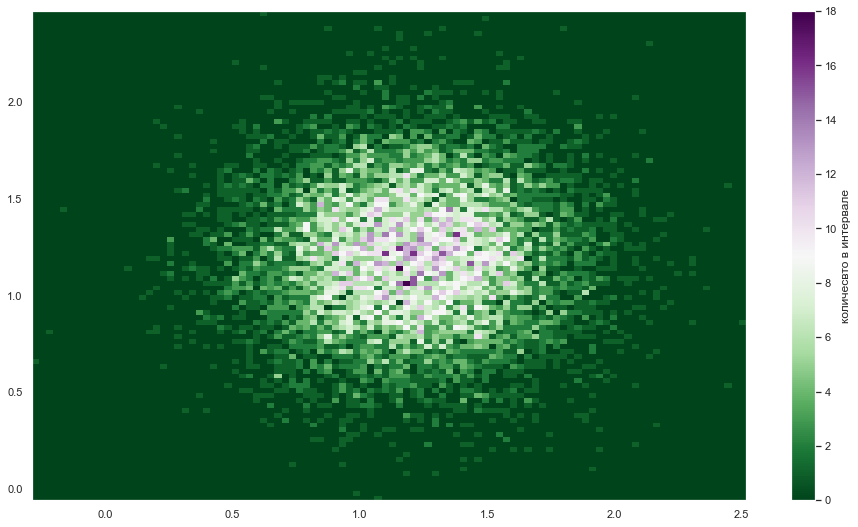

In [43]:
#mean = gmm.means_[1]
#cov = gmm.covariances_[1]
#x,y = np.random.multivariate_normal(mean, cov, 1000).T
plt.cm.PRGn_r
plt.hist2d(s0,s00,bins=100, cmap='PRGn_r')
#plt.hist2d(s1,s11,bins=100, cmap='PRGn_r')
cb = plt.colorbar()
cb.set_label('количесвто в интервале')

# Анализ EM кластеризации на несколько элементов (без расчета целевого массива r_target)



In [3]:
data_store = data_store0

## Вывод данных

In [4]:
# Выводим данные из нужной таблицы в рабочий датафрейм
data_store = Valunistoe_Store['202110']
data_store[:3]

NameError: name 'Valunistoe_Store' is not defined

## Препроцессинг

### Выбор элементов для расчета

In [7]:
# 
col = ['Hole-ID','Sample','From','X','Y','Au_rand']
col_ = col[3:]
print(col_ )
data = data_store[col].dropna()
data_= data[col_]
data_.head()

['X', 'Y', 'Au_rand']


,X,Y,Au_rand
0,-152743.938126,1.067674e+06,0.071
1,-152743.613367,1.067674e+06,4.500
2,-152743.180354,1.067674e+06,5.000
3,-152742.747341,1.067674e+06,2.135
4,-152742.314329,1.067673e+06,0.007


### Подготовка основных элементов (логарифмирование, изменение знаков и т.д.)

In [6]:
# логарифмирование основного элемента
#data.loc[:, el]= np.log(data[el] * 100) # Логаоифмируем по значениям увеличенным на 100
#data.loc[:, 'X'] = data['X'] * -1      # Делаем значения положительными

for i in data_.columns:
    if(data_[i].dtype == 'float64' or data_[i].dtype == 'float32'):
        data_.loc[:, i]= np.log(data_[i])# * 1000

data_.describe()

C:\Users\Sergey.Miklovda\Anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Sergey.Miklovda\Anaconda3\lib\site-packages\pandas\core\indexing.py:1843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,X,Y,Au_rand
count,0.0,184278.000000,184278.000000
mean,NaN,13.881254,-1.457807
std,NaN,0.000806,1.862004
min,NaN,13.878313,-6.907755
25%,NaN,13.880579,-2.718101
50%,NaN,13.881059,-1.560648
75%,NaN,13.881789,-0.287682
max,NaN,13.882992,7.600902


### Препроцессинг (MinMaxScaller)

In [8]:
from sklearn import preprocessing
#dataNorm = preprocessing.MinMaxScaler().fit_transform(data_.values) #.values
dataNormPrepr = preprocessing.MinMaxScaler()
dataNormPrepr.fit(data_.values)
dataNorm = dataNormPrepr.transform(data_.values)
print(dataNorm)


#data_0 = dataNormPrepr.inverse_transform(dataNorm)
#data_0

[[2.69261458e-01 5.72313903e-01 3.50000175e-05]
 [2.69354506e-01 5.72276354e-01 2.24950112e-03]
 [2.69478569e-01 5.72226288e-01 2.49950125e-03]
 ...
 [3.01275778e-01 7.71222678e-01 3.35000168e-05]
 [3.01062352e-01 7.71227233e-01 3.30000165e-05]
 [3.00848926e-01 7.71231788e-01 4.10000205e-05]]


In [ ]:
# Вывод в Excel
out_path = r'C://Users/Sergey.Miklovda/Desktop/WORK_MATERIALS/VAE/VAE_2021/Valunistoe_preprocessing3.xlsx'
#input("Введите путь к файлу вывода__")
dn = pd.DataFrame(dataNorm)
dn.to_excel(out_path)

## Features matrix (n_samples, n_features) Матрица признаков

In [9]:
X_data = dataNorm

#X_data = dataNorm.drop(['Au', 'cat', 'Au_log'], axis=1)
X_data.shape

(184278, 3)

## Расчет количества кластеров

### Подготовка данных на основе n - случайной выборки из матрицы признаков

In [10]:
n_samlpes = 50000
data_dist = pdist(X_data[np.random.randint(0, len(X_data), n_samlpes)], 'euclidean') #X_data[50000:100000,]  np.random.randint(0, len(X_data), n))
data_linkage = linkage(data_dist[~np.isnan(data_dist)], method = 'average')

### Графическое отображение кривых количества кластеров

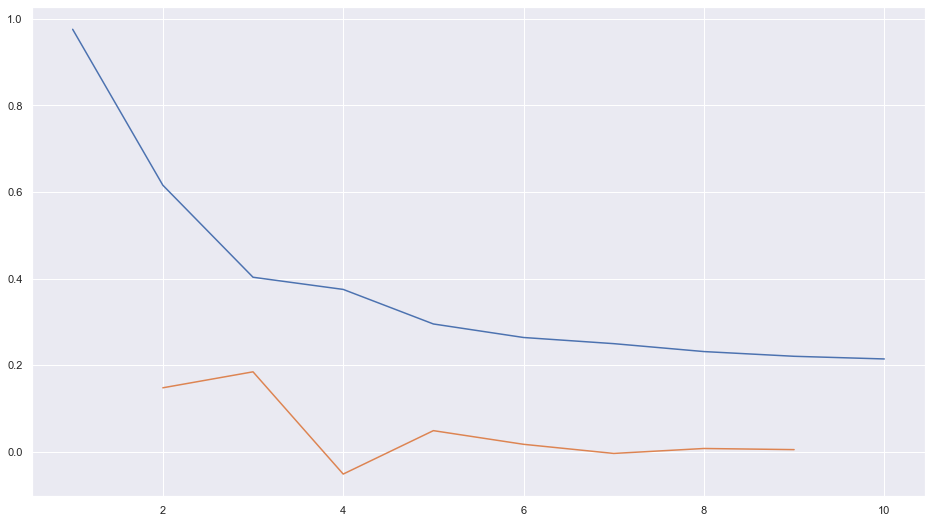

Рекомендованное количество класстеров:  3


In [11]:
last = data_linkage[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2
print("Рекомендованное количество класстеров: ", k)
# Желтая - динамика изменения расстояния между кластерами
# Синяя - абсолютное изменение расстояния между кластерами

### Графическое отображение количества кластеров расчитанных методом AIC, BIC

In [12]:
# ОБУЧЕНИЕ МОДЕЛИ НА 1-10 КОМПОНЕНТАХ
k_arr = np.arange(20) + 1

models = [
GaussianMixture(n_components=k, covariance_type='full', random_state=0).fit(X_data)
for k in k_arr
]

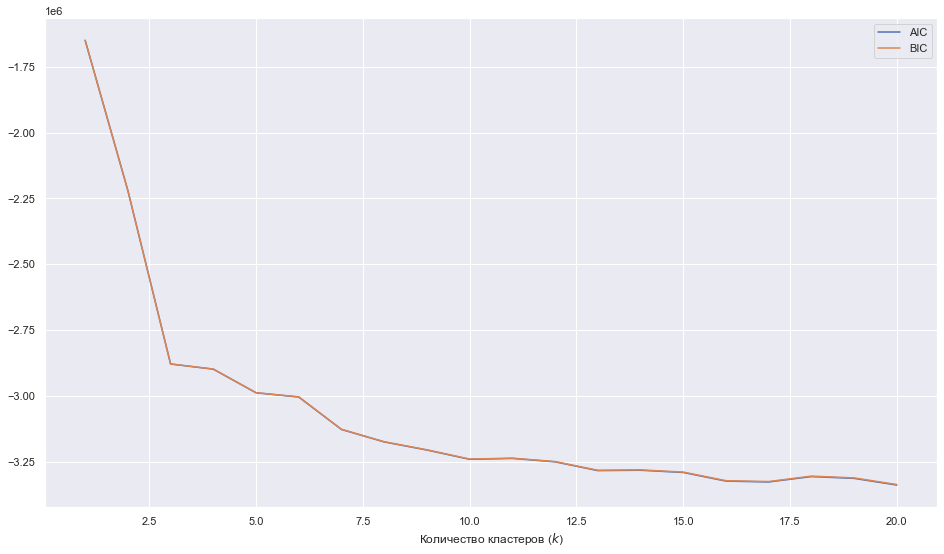

In [13]:
# Compute metrics to determine best hyperparameter
AIC = [m.aic(X_data) for m in models]
BIC = [m.bic(X_data) for m in models]
# Plot these metrics
plt.plot(k_arr, AIC, label='AIC')
plt.plot(k_arr, BIC, label='BIC')
plt.xlabel('Количество кластеров ($k$)')
plt.legend()

## Обучение модели (по расчитанным компонентам) и предикт

In [ ]:
n_komponents= 7 # Ранее определенное количесвто компонентов 

gmm = GaussianMixture(n_components=n_komponents)
gmm.fit(X_data)

#data.loc[:,'EM_Cluster'] = gmm.predict(X_data)
data.loc[:,'EM_3d_Cluster'] = gmm.predict(X_data)
data[:2]

In [ ]:
for n in range(0, n_komponents):
    print("means_" , n , gmm.means_[n].round(3),)#[3:].round(3)

In [ ]:
# Вывод в Excel
out_path = r'C://Users/Sergey.Miklovda/Desktop/WORK_MATERIALS/VAE/VAE_2021/Valunistoe_EM_2d(7_clusters).xlsx'
#input("Введите путь к файлу вывода__")
data.to_excel(out_path)

## Кластеризация закончена

# дополнительные работы

## Работа с целевым массивом (target) категориальных данных

### Создание столбца категорий

In [ ]:
# Разделение по содержанию
# добавляем имена для групп
ranges = [0.0005,1.6, 2.1, 4000]  #1.2, 
labels = ['Убогие', 'Бедные',  'Балансовые'] #'Средние',
cat_col = pd.cut(data[el], ranges, labels=labels)
#d= data[col]
data['cat'] = cat_col 
data[:3]

## Генерация новых значений на основе расчитанных кластеров

### Создание новых значений

In [ ]:
# Возможная генерация новых значений по расчитанному алгоритму
n= 100000
data_n = gmm.sample(n_samples = n)
data_new =list(data_n)
#print(data_new[:2])
data_new_1 = data_new[0:n][0]
data_new_2 = data_new[0:n][1]
print('data_new_1 ____', data_new_1)
print('data_new_2 ____', data_new_2)


### Инверсия значений в первоначальные данные

In [ ]:
# Инверсия значений в первоначальные данные и добавление столбца кластеров

data_inv = np.column_stack([dataNormPrepr.inverse_transform(data_new_1), data_new_2])
print(data_inv[:2])

### Объединение инверсированных данных с исходными

In [ ]:
# Подготовка новых данных к объединению с data
data_invers = pd.DataFrame(data_inv) 

data_invers.rename(columns= {0: 'Au', 1 : 'Ag', 2 : 'Zn', 3 : 'Pb', 4 : 'EM_Cluster'}, inplace=True ) 

data_invers.insert(0, 'ОБЪЕКТ', 'NEW')
data_invers.insert(1, 'ПРОБА_НОМЕР', np.random.randint(0, n, n))
#data_invers.insert(5, el,np.nan )
data_invers[:2]



In [ ]:
# ОБъединение с дата

data_concat = pd.concat([data, data_invers])
data_concat.shape

In [ ]:
data_concat[::20]
data_concat.describe()

In [ ]:
el = 'Au'

X= data_concat[el]
kwargs = dict(histtype= 'stepfilled', alpha=0.3,  bins=50) #normed= True,
plt.hist(np.log(X), **kwargs) #np.log(X)

## Метод Главных компонент (PCA - principal component analysis)

In [ ]:
from sklearn.decomposition import PCA  # 1. Choose the model class

### Выбор количества компонент

In [ ]:
pca = PCA(0.90).fit(X_data)
n_components = pca.n_components_
n_components


### Отображение количества компонент

In [ ]:
#pca = PCA(0.9).fit(X_data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('количество компонент')
plt.ylabel('интегральная объяснимая дисперсия');

### PCA преобразование

In [ ]:
#from sklearn.decomposition import PCA  # 1. Choose the model class
pca = PCA(n_components=n_components)            # 2. Instantiate the model with hyperparameters
pca.fit(X_data)                      # 3. Fit to data. Notice y is not specified!
X_pca = pca.transform(X_data)         # 4. Transform the data to two dimensions

print("Исходная форма:  ", X_data.shape)
print("Трансформированная форма:  ", X_pca.shape)
print('Исходные данные  ', X_data[:3])
print('Преобразованные данные  ', X_pca[:3])


### PCA Инверсия 

In [ ]:
X_invPCA = pca.inverse_transform(X_pca)
print(X_invPCA[:3])

# Экспорт в Excel

In [ ]:
# Вывод в Excel
out_path = r'C:\Users\Sergey.Miklovda\Desktop\WORK_MATERIALS\NSH\MICROMINE_PROJECTS\NSH_clastering_and_analitics\DB\IPYNB\data_4el_0602.xlsx'
#input("Введите путь к файлу вывода__")
data.to_excel(out_path)
#data_concat.to_excel(out_path)